In [47]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW, lr_scheduler as LRScheduler

from transformers import get_scheduler

from jre_utils.datapath import model_ready_data_paths
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.metrics import MSELossWeighted
from jre_utils.engine import (
    evaluate,
    train,
    evaluate_weightless,
    train_weightless,
    EarlyStopper,
)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [48]:
metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
}

metric_key = "weighted_median"
metric = metrics[metric_key]
smoothed_metric = f"{metric}_smoothed"
metric_pct_chg = smoothed_metric + "_pct_chg"
normalized_metric_pct_chg = "normalized_" + smoothed_metric + "_pct_chg"

In [49]:
start_year = 2006
eval_start_year = 2020 # eval_years = [2020, 2021]

dataset_key = "transactions"
years_ahead = 2
model_ready_data_path = model_ready_data_paths[f"sequence_{dataset_key}_{metric_key}_{years_ahead}"]

df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= 2021]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)

df[normalized_metric_pct_chg] = df.groupby("year")[
    metric_pct_chg
].transform(lambda x: (x - x.mean()) / x.std())

train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)]
eval_df = df[df["year"] >= eval_start_year]

In [76]:
train_df[train_df["area_code"] == 13101][["year", smoothed_metric, metric_pct_chg, normalized_metric_pct_chg]]

,year,unit_price_wmedian_smoothed,unit_price_wmedian_smoothed_pct_chg,normalized_unit_price_wmedian_smoothed_pct_chg
83,2006,2.980588e+06,0.533101,-0.186925
1063,2007,3.190579e+06,0.121657,-0.457810
2306,2008,3.144827e+06,0.055103,-0.416249
2827,2009,2.910509e+06,-0.087780,-0.211171
4706,2010,2.697234e+06,-0.142327,-0.224379
6408,2011,2.354779e+06,-0.190939,-0.499622
7946,2012,2.224987e+06,-0.175086,-0.625477
9228,2013,2.791684e+06,0.185540,0.855878
10803,2014,3.167834e+06,0.423754,1.575156
11855,2015,3.297759e+06,0.181280,0.744014


In [56]:
eval_df[eval_df["area_code"] == 13101]

,unit_price_wmedian_smoothed_pct_chg,unit_price_wmedian_smoothed,year,years_since_crisis,count,total_traded_area,population,taxpayer_count,taxable_income,taxable_income_per_taxpayer,taxable_income_growth,taxable_income_per_taxpayer_growth,total_tax,total_tax_growth,new_dwellings,existing_dwellings,net_migration_ratio,new_dwellings_ratio,migrations_is_available,taxable_income_is_available,dwellings_is_available,total_tax_is_available,area_code,normalized_unit_price_wmedian_smoothed_pct_chg,unit_price_wmedian_smoothed_normalized,unit_price_wmedian_smoothed_pct_chg_normalized,count_normalized,total_traded_area_normalized,population_normalized,taxpayer_count_normalized,taxable_income_normalized,taxable_income_per_taxpayer_normalized,taxable_income_growth_normalized,taxable_income_per_taxpayer_growth_normalized,new_dwellings_normalized,existing_dwellings_normalized,new_dwellings_ratio_normalized,net_migration_ratio_normalized,total_tax_normalized,total_tax_growth_normalized,migrations_is_available_normalized,taxable_income_is_available_normalized,dwellings_is_available_normalized,total_tax_is_available_normalized,count_scaled
19216,0.065080,4.106235e+06,2020,1,41.0,5665.0,66680.0,39873.0,400984266.0,10056.536152,-0.028845,-0.070201,20573851.0,-0.049652,1159.0,43646.0,0.014607,0.026555,1,1,1,1,13101,0.225172,24.262806,-0.036866,-0.174173,-0.365424,-0.088408,0.013398,0.779952,12.298335,-0.575923,-1.688231,0.297480,0.070781,2.155268,2.625367,0.192742,-0.796051,0.152705,0.067585,0.907427,0.060948,1.029349
20964,0.070969,4.260203e+06,2021,2,48.0,7520.0,66615.0,40423.0,398238882.0,9851.789377,-0.006847,-0.020360,20725904.0,0.007391,787.0,44433.0,-0.000976,0.017712,1,1,1,1,13101,0.086645,25.188093,-0.027676,-0.137899,-0.317633,-0.088728,0.019289,0.772092,11.948322,-0.146201,-0.481597,0.099772,0.078542,1.146515,0.386365,0.196639,0.001263,0.152705,0.067585,0.907427,0.060948,1.034359


In [57]:
columns = [
    smoothed_metric,
    metric_pct_chg,
    "count",
    "total_traded_area",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "new_dwellings",
    "existing_dwellings",
    "new_dwellings_ratio",
    "net_migration_ratio",
    "total_tax",
    "total_tax_growth",
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
]
columns_normalized = [f"{col}_normalized" for col in columns]

train_df_mean = train_df[columns].mean()
train_df_std = train_df[columns].std()
train_df[columns_normalized] = (train_df[columns] - train_df_mean) / train_df_std
eval_df[columns_normalized] = (eval_df[columns] - train_df_mean) / train_df_std

count_scale_factor = 3
count_max = train_df["count"].max()
train_df["count_scaled"] = 1 + (train_df["count"] / count_max) * 3
eval_df["count_scaled"] = 1 + (eval_df["count"] / count_max) * 3

df = pd.concat([train_df, eval_df])

# more detailed area level normalization would help

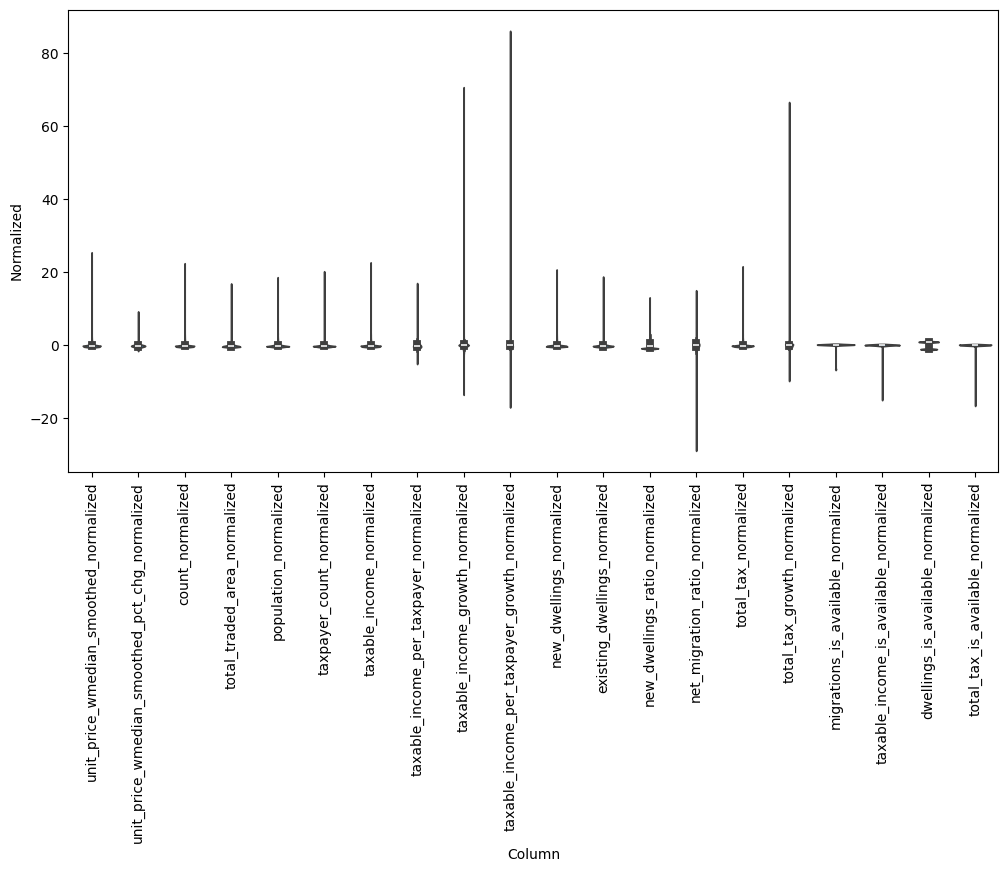

In [58]:
df_std = df[columns_normalized].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df[columns_normalized].keys(), rotation=90)

In [59]:
# Will yearly normalized columns be better?
# If average net migration higher for factor area X over area Y in the same year, I would think it would have higher return
# Compared to normalizing over all years. That also gives us access to future years which is undesirable

columns_normalized_yearly = [f"{col}_normalized_yearly" for col in columns]
for col in columns:
    df[f"{col}_normalized_yearly"] = df.groupby("year")[col].transform(
        lambda x: (x - x.mean()) / x.std()
    )

# To account for years where the data is not available and all the values are zero. In those situations, the normalized values will be NaN.
df = df.fillna(0)

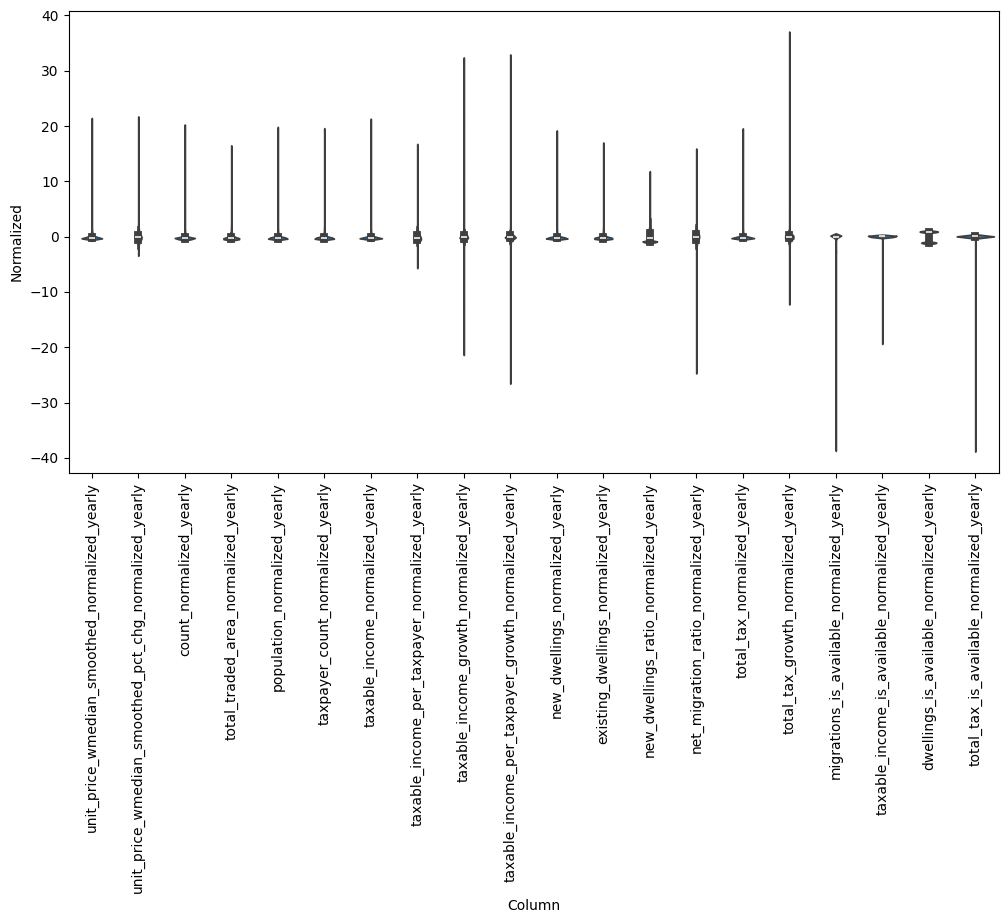

In [60]:
df_std = df[columns_normalized_yearly].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df[columns_normalized_yearly].keys(), rotation=90)

In [61]:
feature_columns = [metric_pct_chg] + columns_normalized_yearly + ["migrations_is_available", "taxable_income_is_available", "dwellings_is_available"]

time_series_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    feature_columns=feature_columns,
    shift=years_ahead
)

time_series_dataset_transformed = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    shift=years_ahead
)

for i, sampleX in enumerate(time_series_dataset):
    print(
        i,
        sampleX["window"].shape,
        sampleX["target"].shape,
        sampleX["target"].values,
        sampleX["weight"].values,
    )
    if i == 3:
        break


for i, sampleY in enumerate(time_series_dataset_transformed):
    print(
        i,
        sampleY["window"].shape,
        sampleY["target"].shape,
        sampleY["target"],
        sampleY["weight"],
    )
    if i == 3:
        break

0 (0, 24) (1,) [2.08435467] [1.10379384]
1 (0, 24) (1,) [-0.37498963] [1.00071582]
2 (0, 24) (1,) [0.00051067] [1.02004295]
3 (0, 24) (1,) [0.24327261] [1.00214746]
0 torch.Size([5, 24]) torch.Size([1]) tensor([2.0844]) tensor([1.1038])
1 torch.Size([5, 24]) torch.Size([1]) tensor([-0.3750]) tensor([1.0007])
2 torch.Size([5, 24]) torch.Size([1]) tensor([0.0005]) tensor([1.0200])
3 torch.Size([5, 24]) torch.Size([1]) tensor([0.2433]) tensor([1.0021])


In [62]:
BATCH_SIZE = 256

In [63]:
train_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)
eval_dataset = JapanRETimeSeriesDataset(
    df,
    eval_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21902 entries, 61 to 21962
Data columns (total 65 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   unit_price_wmedian_smoothed_pct_chg                    21902 non-null  float64
 1   unit_price_wmedian_smoothed                            21902 non-null  float64
 2   year                                                   21902 non-null  int64  
 3   years_since_crisis                                     21902 non-null  int64  
 4   count                                                  21902 non-null  float64
 5   total_traded_area                                      21902 non-null  float64
 6   population                                             21902 non-null  float64
 7   taxpayer_count                                         21902 non-null  float64
 8   taxable_income                               

### Building the Transformer Model

In [65]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [66]:
n_features = len(feature_columns)
d_model = 256
d_hid = 256
nlayers = 8
nhead = 8
dropout = 0
enc_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    enc_dropout=enc_dropout,
    device=device,
)
model = model.to(device)


In [67]:
%%timeit

model.eval()

mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)
        
        print("Loss:", loss.item())

        break

torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.4945040941238403
torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.4945040941238403
torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.4945040941238403
torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.4945040941238403
torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.4945040941238403
torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.4945040941238403
torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.4945040941238403
torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256,

In [68]:
# Write a pretraining loop to go over all datasets and pretrain on that
# Use early stopping and regularization so you don't have to worry about overfitting
# Write the required parameters and processing functions for all the datasets and put them all in a dictionary

def extract_transformer_encoder_state_dict(state_dict):
    transformer_state_dict = {}
    for key, value in state_dict.items():
        if "transformer_encoder" in key:
            transformer_state_dict[key] = value
    return transformer_state_dict

# loaded_state_dict = extract_transformer_encoder_state_dict(torch.load("../../weights/jena_climate.pt"))
# model.load_state_dict(loaded_state_dict, strict=False)


In [69]:
learning_rate = 1e-4 # 3e-4
weight_decay = 1 # 1
num_epochs = 200

In [70]:
num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = get_scheduler(
    "constant",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [71]:
# progress_bar = tqdm(range(num_training_steps))
progress_bar = None

for epoch in range(num_epochs):
    train_loss, train_r2_score = train(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)
    
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
    print(f"Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")

# progress_bar.close()

Epoch: 0
Train Loss: 4.2031, Eval Loss: 3.9185
Train R^2: -0.0304, Eval R^2: 0.0332
Epoch: 1
Train Loss: 3.5873, Eval Loss: 2.5920
Train R^2: 0.1196, Eval R^2: 0.3626
Epoch: 2
Train Loss: 3.3227, Eval Loss: 2.0799
Train R^2: 0.1854, Eval R^2: 0.4886
Epoch: 3
Train Loss: 3.0446, Eval Loss: 1.9022
Train R^2: 0.2532, Eval R^2: 0.5319
Epoch: 4
Train Loss: 2.8229, Eval Loss: 1.7908
Train R^2: 0.3076, Eval R^2: 0.5592
Epoch: 5
Train Loss: 2.6335, Eval Loss: 1.7766
Train R^2: 0.3543, Eval R^2: 0.5625
Epoch: 6
Train Loss: 2.5090, Eval Loss: 1.7239
Train R^2: 0.3849, Eval R^2: 0.5754
Epoch: 7
Train Loss: 2.4404, Eval Loss: 1.6825
Train R^2: 0.4018, Eval R^2: 0.5856
Epoch: 8
Train Loss: 2.3767, Eval Loss: 1.6558
Train R^2: 0.4175, Eval R^2: 0.5921
Epoch: 9
Train Loss: 2.3717, Eval Loss: 1.6408
Train R^2: 0.4190, Eval R^2: 0.5958
Epoch: 10
Train Loss: 2.3069, Eval Loss: 1.6508
Train R^2: 0.4351, Eval R^2: 0.5941
Epoch: 11
Train Loss: 2.2720, Eval Loss: 1.6342
Train R^2: 0.4436, Eval R^2: 0.5980
E

KeyboardInterrupt: 

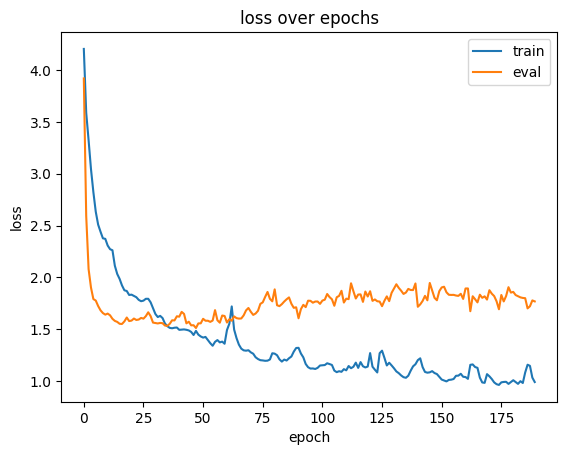

In [72]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

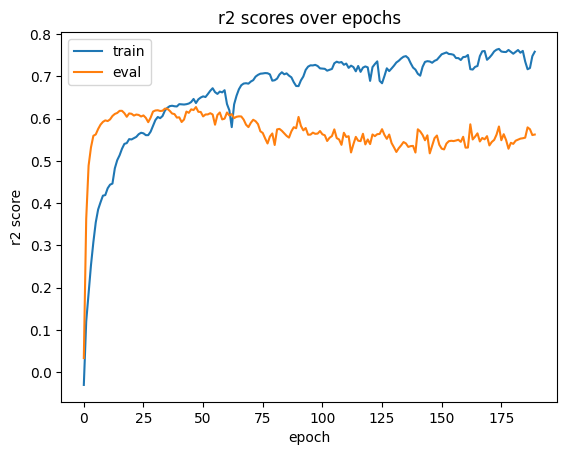

In [73]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()

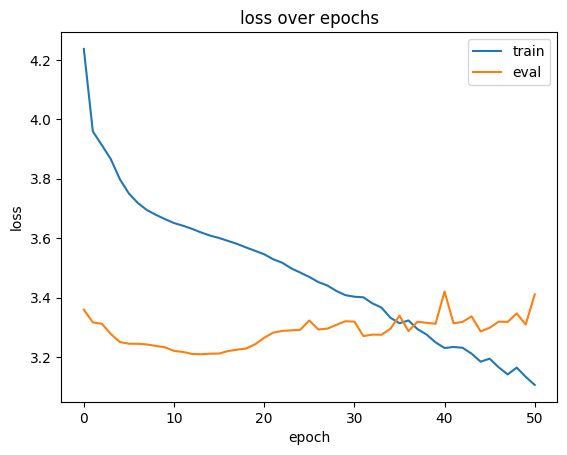

In [210]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

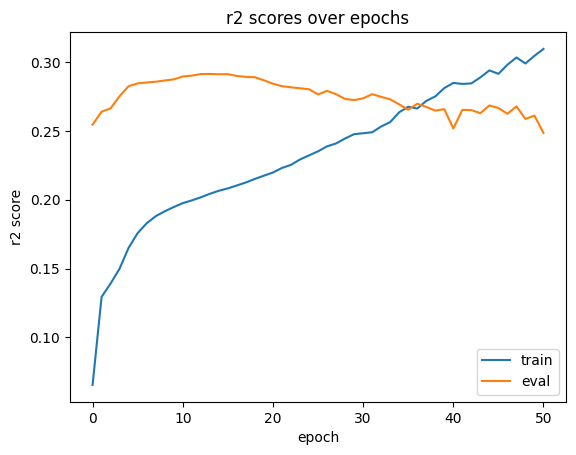

In [211]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()

In [32]:
# untrained model
loss, epoch_r2_score = evaluate(model, eval_dataloader, device=device)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_r2_score:.4f}")

Eval loss: 3.4521
Eval R2: 0.1688


### Pretraining and transfer gameplan

Within my time series model, I have the Transformer Encoder and the Positional Encoder. 
Once the model is done training, I will take the weights and save it to a file.
Then, I will load up the new model with this file.



In [103]:
test_year = 2021

presentation_df = df[df["area_code"].astype(int) // 1000 == 13]
presentation_df = presentation_df[presentation_df["year"] == test_year]
presentation_dataset = TimeSeriesDataset(
    df,
    presentation_df,
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)
presentation_dataloader = None

In [106]:
next(iter(presentation_dataloader))['window'].shape

torch.Size([49, 5, 14])

In [109]:
tokyo_dataset = next(iter(presentation_dataloader))
model.eval()
tokyo_output = model(tokyo_dataset['window'].to(torch.float32).to(device), tokyo_dataset['mask'].to(torch.float32).to(device))

In [110]:
tokyo_output

tensor([[ 0.0130],
        [-0.0186],
        [ 0.0277],
        [ 0.0216],
        [ 0.0877],
        [ 0.0506],
        [ 0.0254],
        [ 0.0862],
        [-0.0248],
        [-0.0092],
        [-0.1615],
        [-0.0008],
        [-0.2429],
        [-0.0291],
        [-0.0184],
        [-0.0267],
        [ 0.0206],
        [ 0.0577],
        [ 0.0117],
        [ 0.0127],
        [ 0.0254],
        [ 0.0156],
        [ 0.0252],
        [-0.0175],
        [ 0.0059],
        [-0.0571],
        [ 0.0357],
        [-0.0107],
        [-0.0207],
        [ 0.0368],
        [ 0.0526],
        [ 0.0167],
        [-0.1445],
        [ 0.0624],
        [ 0.0102],
        [-0.0105],
        [-0.0181],
        [-0.0953],
        [ 0.0091],
        [ 0.0136],
        [ 0.0164],
        [ 0.0693],
        [ 0.0277],
        [-0.0114],
        [ 0.0668],
        [ 0.0488],
        [ 0.0630],
        [-0.0585],
        [ 0.0442]], device='mps:0', grad_fn=<LinearBackward0>)

### Important Questions:
1. What is the optimal error?
2. What is the human level error?
3. How much better or worse is the model compared to human level error?

My assumption is that optimal error is zero %, and human level error is close to that. 
But it is likely that the human level error is considerably worse.

### The High Variance Problem

The model is overfitting right now